# Машинное обучение, ЭФ МГУ

## Практическое задание 2

### Формат сдачи
* Ноутбук Prac2_<Фамилия>_<Имя>.ipynb
* Модуль utils.py

In [1]:
import os
import time
from tqdm.notebook import tqdm
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
DATA_PATH = "./data"

In [4]:
# Если данной библиотеки нет - её надо установить (в терминале  pip install category_encoders==2.2.2)
# или в прямо в юпитер ноутбуке: !pip install category_encoders==2.2.2
import category_encoders
from category_encoders import TargetEncoder

In [5]:
category_encoders.__version__

'2.2.2'

In [6]:
# Вспомогательная функция для визуализации решающей поверхности модели
def plot_surface(clf: callable, X: np.array, y: np.array, **kwargs):
    
    """
    Args:
        clf: классификатор, у которого есть метод .predict()
        X: матрица Объект-Признак
        y: вектор классов
    """
    
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2, **kwargs)

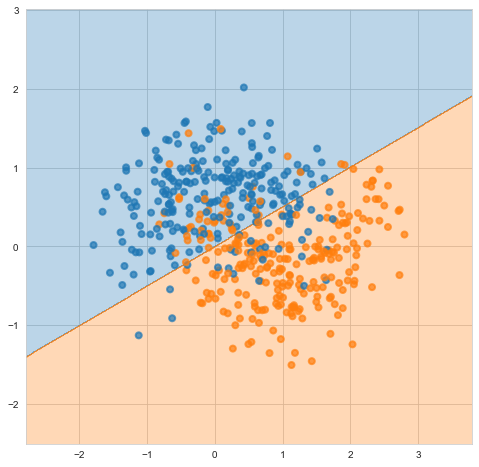

In [7]:
# Пример работы функции:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.4)
lr  = LogisticRegression().fit(X, y)
plot_surface(lr, X, y)

__Задание 1 (1 балл)__

Визуализируйте решающую поверхность дерева для выборки выше.

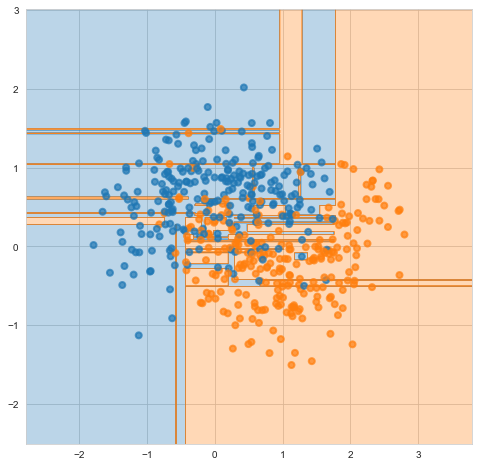

In [8]:
# Ваш код здесь:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier().fit(X, y)
plot_surface(dec_tree, X, y)

__Задание 2 (3 балла за график + 1 балл за ответ)__

Попробуйте перебрать несколько параметров для `max_depth` и `min_samples_leaf`. Для каждого набора гиперпараметров постройте разделяющую поверхность (на одной картинке сеткой), выведите обучающую и тестовую метрики качества (Accuracy). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит? 

In [9]:
from sklearn.metrics import accuracy_score

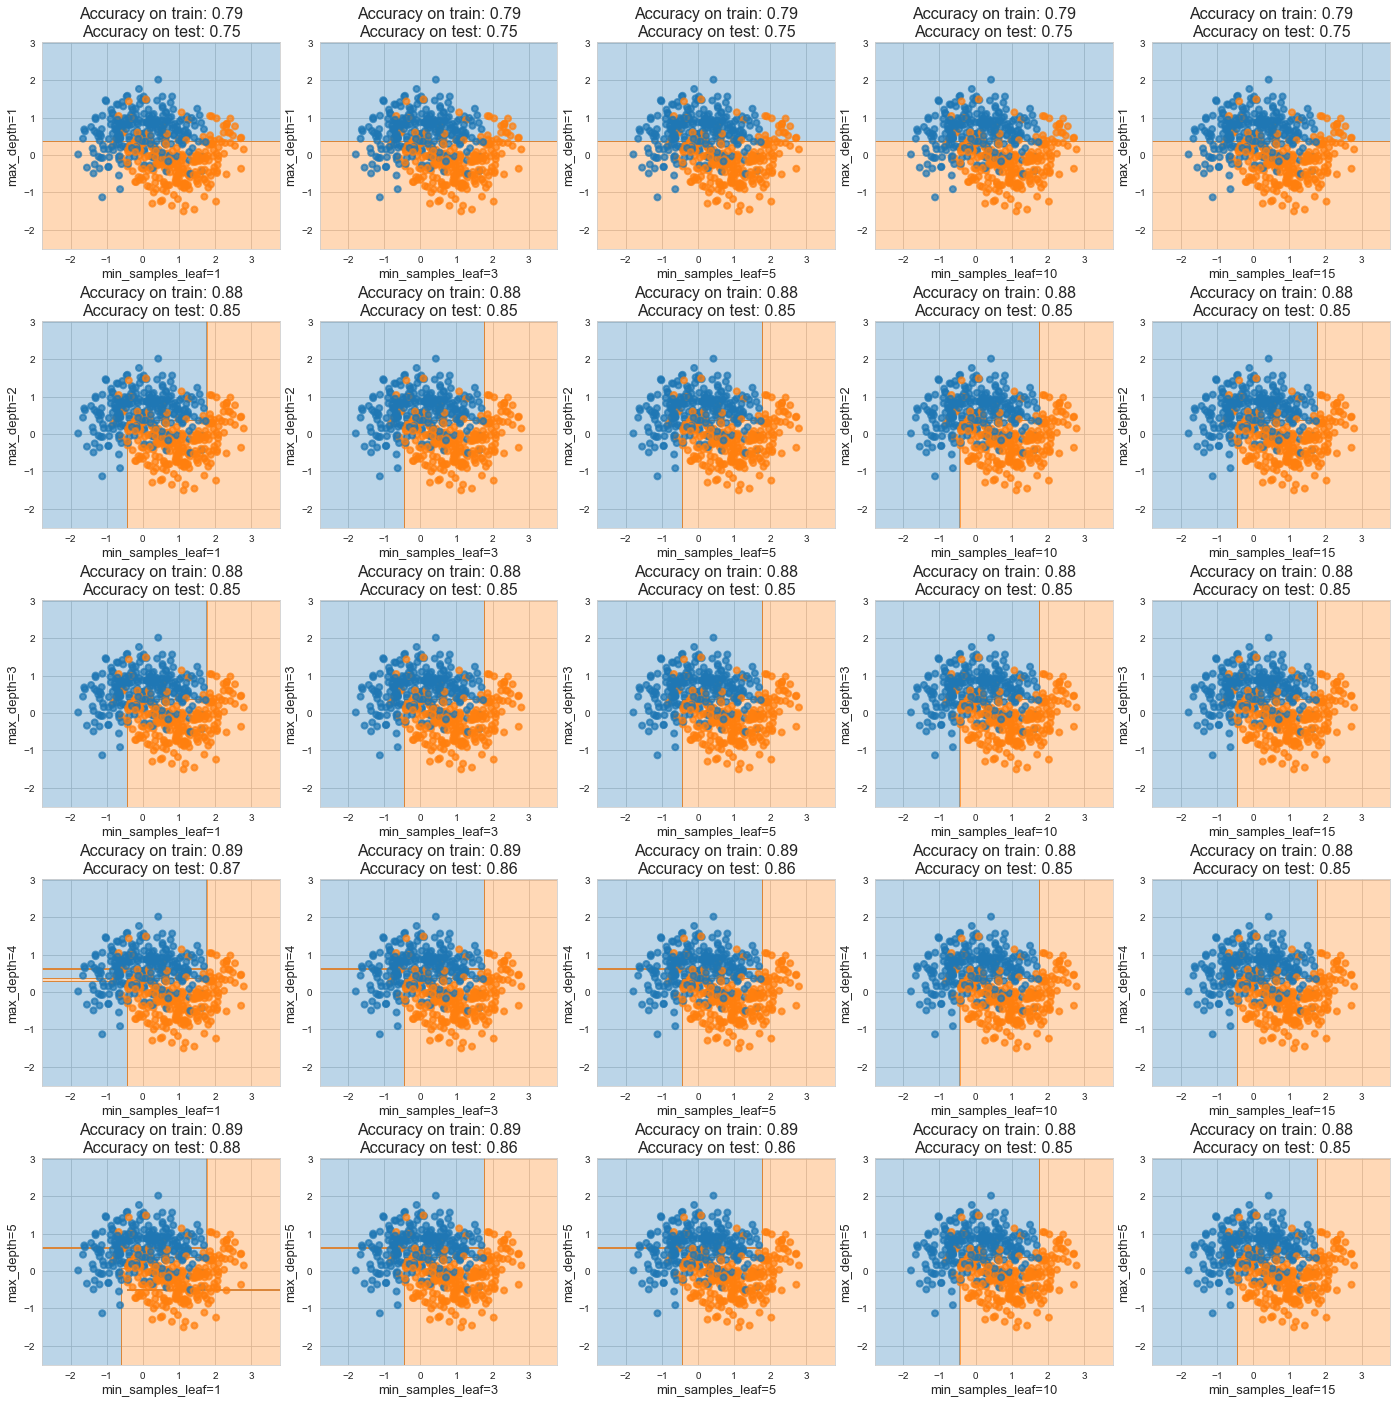

In [10]:
# Ваш код здесь:
fig = plt.figure(figsize=(20, 20))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
i = 1

for depth in tqdm(np.arange(1, 6)):
    for samples_leaf in [1, 3, 5, 10, 15]:
        ax = fig.add_subplot(5, 5, i)
        dec_tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_leaf).fit(X, y)
        acc_train = round(accuracy_score(y_true=y_train, y_pred=dec_tree.predict(X_train)), 2)
        acc_test = round(accuracy_score(y_true=y_test, y_pred=dec_tree.predict(X_test)), 2)
        
        plot_surface(dec_tree, X, y)
        plt.title('Accuracy on train: '+str(acc_train)+'\nAccuracy on test: '+str(acc_test), fontsize=16)
        plt.xlabel('min_samples_leaf='+str(samples_leaf), fontsize=13)
        plt.ylabel('max_depth='+str(depth), fontsize=13)
        
        i += 1

__Ответ:__

При прочих равных чем больше глубина дерева, тем более переобученную модель мы получаем и тем более причудливая форма у разделяющей поверхности. Так происходит потому, что мы позволяем дереву ветвиться и через несколько отсечений возможна ситуация, когда мы обрубили небольшое количество элементов в отдельный сектор (т.е. переобучили). Это выражается в тонких полосках, уходящих в бесконечность на разделяющей поверхности. Также при увеличении числа минимального количества элементов в листе мы избавляемся от переобучения и бесконечно длинных полосок, так как дереву уже не удаётся выделить мелкие сегменты по 2-3 наблюдения.

### Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3 (2 балла)__

Реализуйте функцию подсчёта impurity листа (compute_criterion) и сохраните её в utils.py

In [11]:
from utils import compute_criterion

In [12]:
print('Gini:', compute_criterion(target_vector=np.array([1, 1, 1, 2, 2, 2, 3, 3, 3]), 
                                 feature_vector=np.arange(9), 
                                 threshold=4, 
                                 criterion='gini'))
print('Entropy:', compute_criterion(target_vector=np.array([1, 1, 1, 2, 2, 2, 3, 3, 3]), 
                                    feature_vector=np.arange(9), 
                                    threshold=4, 
                                    criterion='entropy'))

Gini: 0.23333333333333345
Entropy: 0.6849774484867257


__Задание 4 (3 балла)__

Реализуйте функцию find_best_split из модуля utils.py

In [13]:
# Предполагается, что вы реализуете эту функцию и запишите её в utils.py
from utils import find_best_split

__Задание 5 (2 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)) (Этот датасет есть по пути: "./data/students.csv"). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одной картинке 5 графиков (сеткой по признакам): распределение j-ого признака при целевой переменной равной 0 и 1 (2 плотности распределения на одном графике).

In [14]:
# Загружаем данные
tmp_df = pd.read_csv(f"{DATA_PATH}/students.csv")
tmp_df.columns = [col.strip() for col in tmp_df.columns]

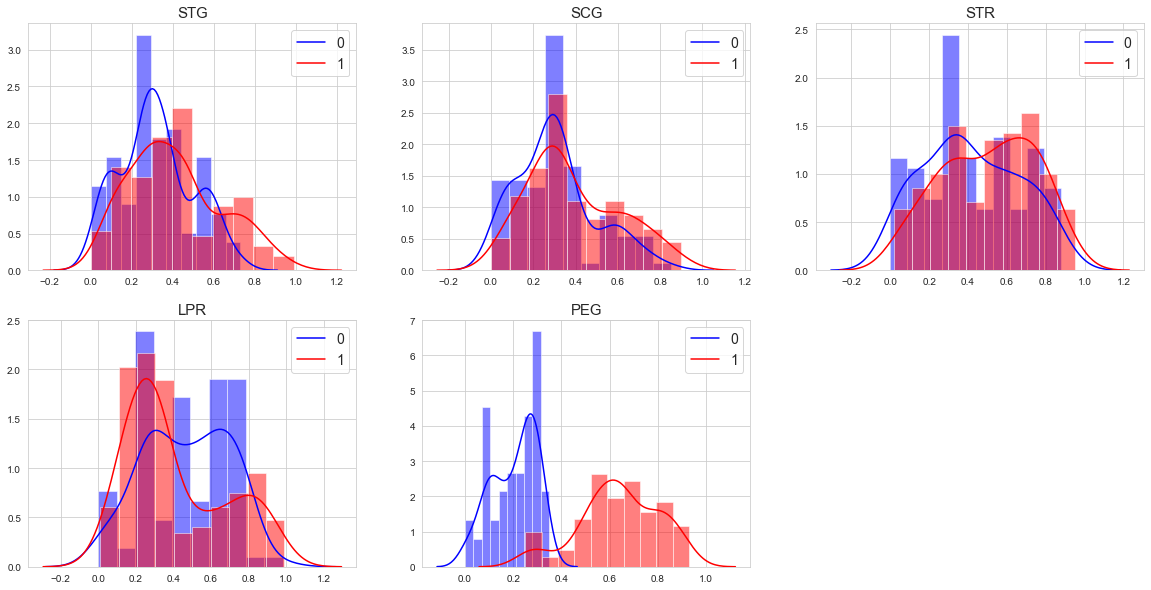

In [15]:
# Ваш код здесь:
fig = plt.figure(figsize=(20, 10))
i = 1

for feat in tmp_df:
    ax = fig.add_subplot(2, 3, i)

    plt.hist(tmp_df[feat][tmp_df['UNS'] == 0], density=True, color='b', alpha=0.5, label='0')
    plt.hist(tmp_df[feat][tmp_df['UNS'] == 1], density=True, color='r', alpha=0.5, label='1')
    
    sns.kdeplot(tmp_df[feat][tmp_df['UNS'] == 0], color='b')
    sns.kdeplot(tmp_df[feat][tmp_df['UNS'] == 1], color='r')

    plt.legend(('0', '1'),  fontsize=14)
    plt.title(feat, fontsize=15)

    i += 1
    if i == 6:
        break


__Задание 6 (2 балла за график + 1 балл за ответ)__

Изобразите на одном графике значения критерий расщипления Джини для каждой переменной (своим цветом для каждой переменной). По какой переменной лучше всего провести первое разбиение? Совпадает ли вывод про лучшую переменную для разбиения из этого графика, с выводом, полученным из графика в задании 5?

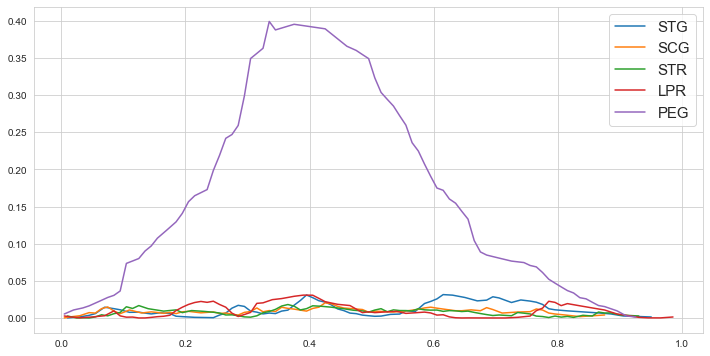

In [16]:
# Ваш код здесь:
plt.figure(figsize=(12, 6))

for feat in tmp_df.loc[:, :'PEG']:
    thresholds, criterion_vals, threshold_best, criterion_best = find_best_split(tmp_df[feat], tmp_df['UNS'], 'gini')
    plt.plot(thresholds, criterion_vals, label=feat)

plt.legend(fontsize=15)
plt.show()

__Ответ:__

Лучше всего провести первое разбиение по признаку PEG, т.к. там наибольшее значение критерия расщепления.
Вывод совпадает с выводом из задания 5, т.к. на графиках визуально легко разделить на две подвыборки по признаку PEG

__Задание 7 (1 балл)__

Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

__Ответ:__

Кривая "хороших" признаков должна иметь довольно низкую дисперсию и устойчивое мат ожидание

Кривые "плохих" признаков распределены равномерно

__Задание 8 (4 балла)__

Разберитесь с уже написанным кодом в классе DecisionTree модуля utils.py. Найдите ошибки в реализации метода \_fit_node, исправьте их.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини или Энтропийному критерию. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется target_encoding преобразование.

In [17]:
from utils import DecisionTree

Проверка, что Ваш код не падает:

In [18]:
model = DecisionTree(feature_types=['real']*(tmp_df.shape[1] - 1), criterion='gini')
model.fit(tmp_df.drop(['UNS'], axis=1).values, tmp_df['UNS'].values)

model = DecisionTree(feature_types=['categorical']*(tmp_df.shape[1] - 1), criterion='gini')
model.fit(tmp_df.drop(['UNS'], axis=1).values, tmp_df['UNS'].values)

И в результате что-то обучилось:

In [19]:
model._tree

{'type': 'nonterminal',
 'feature_type': 'categorical',
 'feature_number': 4,
 'threshold': 0.6637294581200648,
 'left_child': {'type': 'nonterminal',
  'feature_type': 'categorical',
  'feature_number': 2,
  'threshold': 0.7691627216241348,
  'left_child': {'type': 'nonterminal',
   'feature_type': 'categorical',
   'feature_number': 1,
   'threshold': 0.8354369435878268,
   'left_child': {'type': 'nonterminal',
    'feature_type': 'categorical',
    'feature_number': 0,
    'threshold': 0.8423000617858734,
    'left_child': {'type': 'nonterminal',
     'feature_type': 'categorical',
     'feature_number': 3,
     'threshold': 0.8600676849888688,
     'left_child': {'type': 'nonterminal',
      'feature_type': 'categorical',
      'feature_number': 3,
      'threshold': 0.6211177105378596,
      'left_child': {'type': 'terminal', 'class': 0},
      'right_child': {'type': 'nonterminal',
       'feature_type': 'categorical',
       'feature_number': 0,
       'threshold': 0.59263475019

__Задание 9 (3 балла)__

Реализуйте метод _predict_node в utils.py

In [37]:
from utils import DecisionTree

Проверка, что метод реализован правильно и не падает:

In [38]:
model = DecisionTree(feature_types=['categorical']*(tmp_df.shape[1] - 1), criterion='gini')
model.fit(tmp_df.drop(['UNS'], axis=1).values, tmp_df['UNS'].values)

model.predict(tmp_df.drop(['UNS'], axis=1).values)

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

__Задание 10 (1 балл)__

Обучите дерево на признаках LPR и PEG и визуализируйте полученную модель с помощью plot_surface

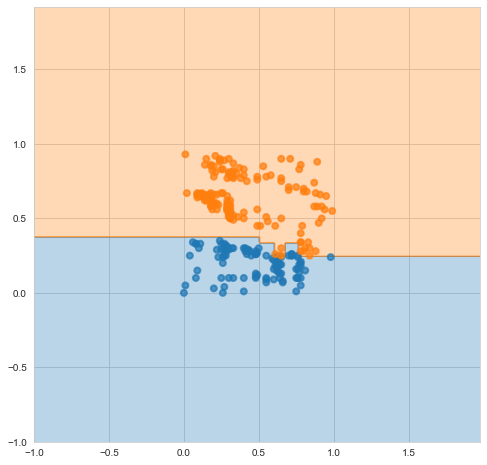

In [22]:
# Ваш код здесь:
model = DecisionTree(feature_types=['real']*2, criterion='gini')
model.fit(tmp_df[['LPR', 'PEG']].values, tmp_df['UNS'].values)

plot_surface(model, tmp_df[['LPR', 'PEG']].values, tmp_df['UNS'].values)

__Задание 11 (2 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)) (этот датасет доступен по пути "./data/agaricus-lepiota.data"), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [24]:
# Загружаем данные
mush_df = pd.read_csv(f"{DATA_PATH}/agaricus-lepiota.data", header=None)

# Делаем маппинг таргетов
mush_target = mush_df[0].map({'e': 0, 'p': 1}).values
mush_X = mush_df.drop([0], axis=1)

# Делаем Label encoding для столбцов:
for col in mush_X.columns:
    # Ваш код здесь: (нужно сделать label encoding столбцов в том же датафрейме mush_X)
    mush_X[col] = LabelEncoder().fit_transform(mush_X[col])

In [25]:
tr_idx, te_idx = np.array_split(np.random.permutation(len(mush_X)), 2)
# Ваш код здесь:
mush_X_tr = mush_X.iloc[tr_idx, :]
mush_target_tr = mush_target[tr_idx]
tree_tr = DecisionTree(feature_types=['categorical']*mush_X.shape[1], criterion='gini')
tree_tr.fit(mush_X_tr.values, mush_target_tr)

mush_X_te = mush_X.iloc[te_idx, :]
mush_target_te = mush_target[te_idx]

print('Accuracy на обучении:', 
      # Ваш код здесь:
      accuracy_score(y_true=mush_target_tr, y_pred=tree_tr.predict(mush_X_tr.values))
     )
print('Accuracy на контроле:', 
      # Ваш код здесь:
      accuracy_score(y_true=mush_target_te, y_pred=tree_tr.predict(mush_X_te.values))
     )

Accuracy на обучении: 1.0
Accuracy на контроле: 1.0


__Бонусное задание (3 балла (по одному за каждый параметр) + 3 балла (по одному за каждый график))__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [44]:
tic_tac_df = pd.read_csv(f"{DATA_PATH}/tic-tac-toe.data", header=None)

X = tic_tac_df.drop([tic_tac_df.shape[1] - 1], axis=1)
y = tic_tac_df.iloc[:, -1].map({'negative': 0, 'positive': 1}).values
for col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col])
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

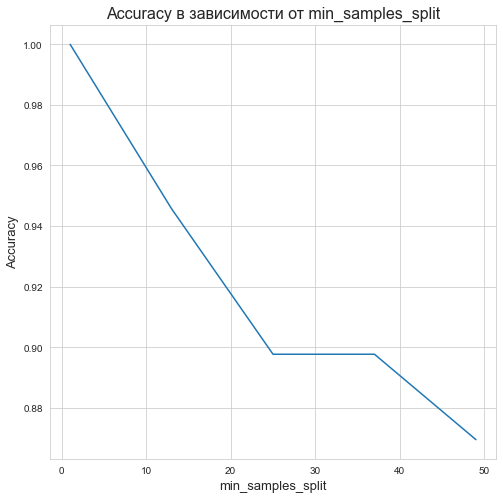

In [40]:
# min_samples_split
samples_splits = np.linspace(1, 49, 5)
accuracies = []

for samples_split in tqdm(samples_splits):
    dec_tree = DecisionTree(feature_types=['categorical']*X.shape[1],
                            min_samples_split=int(samples_split))
    dec_tree.fit(X.values, y)
    accuracies.append(accuracy_score(y_true=y, y_pred=dec_tree.predict(X.values)))
    
plt.plot(samples_splits, accuracies)
plt.title('Accuracy в зависимости от min_samples_split', fontsize=16)
plt.xlabel('min_samples_split', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.show()

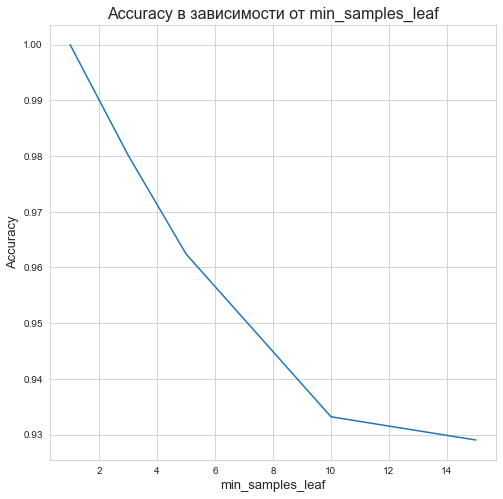

In [45]:
# min_samples_leaf
samples_leaves = [1, 3, 5, 10, 15]
accuracies = []

for samples_leaf in tqdm([1, 3, 5, 10, 15]):
    dec_tree = DecisionTree(feature_types=['categorical']*X.shape[1],
                            min_samples_leaf=samples_leaf)
    dec_tree.fit(X.values, y)
    accuracies.append(accuracy_score(y_true=y, y_pred=dec_tree.predict(X.values)))
    
plt.plot(samples_leaves, accuracies)
plt.title('Accuracy в зависимости от min_samples_leaf', fontsize=16)
plt.xlabel('min_samples_leaf', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.show()

__Задание 12 (4 балла)__

Загрузите следующие наборы данных (Они доступны в "./data/") (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью кросс-валидации (число фолдов = 10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Для первых 3х алгоритмов рекомендуется использовать метод .cv_result

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

In [41]:
%%time 
# ~2мин
datasets_dict = {
    'mushrooms': pd.read_csv(f"{DATA_PATH}/agaricus-lepiota.data", header=None),
    'tic_tac': pd.read_csv(f"{DATA_PATH}/tic-tac-toe.data", header=None),
    'cars': pd.read_csv(f"{DATA_PATH}/car.data", header=None),
    'nursery': pd.read_csv(f"{DATA_PATH}/nursery.data", header=None)
}

# Датафрейм в котором будут собираться результаты по метрике
results_df = pd.DataFrame([], index=[key for key in datasets_dict.keys()], 
                          columns=['DT real', 'DT categorical', 'DT real + OHE', 'DT sklearn'])

# Ваш код здесь:
target_dict = {
    'mushrooms': datasets_dict['mushrooms'][0].map({'e': 0, 'p': 1}).values,
    'tic_tac': datasets_dict['tic_tac'].iloc[:, -1].map({'negative': 0, 'positive': 1}).values,
    'cars': datasets_dict['cars'].iloc[:, -1].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}).values,
    'nursery': datasets_dict['nursery'].iloc[:, -1].map({'not_recom': 0, 'recommend': 0,
                                                 'very_recom': 1, 'priority': 1, 'spec_prior': 1})
}

X_dict = {
    'mushrooms': datasets_dict['mushrooms'].drop([0], axis=1),
    'tic_tac': datasets_dict['tic_tac'].drop([datasets_dict['tic_tac'].shape[1] - 1], axis=1),
    'cars': datasets_dict['cars'].drop([datasets_dict['cars'].shape[1] - 1], axis=1),
    'nursery': datasets_dict['nursery'].drop([datasets_dict['nursery'].shape[1] - 1], axis=1)
}

for X in X_dict.values():
    for col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col])

X_OHE_dict = {}
for key in X_dict.keys():
    X_OHE_dict.update({key: OneHotEncoder().fit_transform(X_dict[key]).toarray()})

i = 0
for key in tqdm(results_df.index[:3]):
    results_df.iloc[i, 0] = np.mean(DecisionTree(feature_types=['real']*X_dict[key].shape[1]).cv_result(X=X_dict[key].values, y=target_dict[key]))
    results_df.iloc[i, 1] = np.mean(DecisionTree(feature_types=['categorical']*X_dict[key].shape[1]).cv_result(X=X_dict[key].values, y=target_dict[key]))
    results_df.iloc[i, 2] = np.mean(DecisionTree(feature_types=['real']*X_OHE_dict[key].shape[1]).cv_result(X=X_OHE_dict[key], y=target_dict[key]))
    results_df.iloc[i, 3] = np.mean(cross_val_score(DecisionTreeClassifier(), X=X_dict[key].values, y=target_dict[key], cv=10))
    i += 1


results_df


Wall time: 1min 47s


,DT real,DT categorical,DT real + OHE,DT sklearn
mushrooms,1,1,1,0.956689
tic_tac,0.883202,0.953015,0.954046,0.789419
cars,0.993621,0.990157,0.991319,0.942707
nursery,NaN,NaN,NaN,NaN


__Задание 13 (1 балл)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Нет, не одинаково. В mushrooms и cars точность примерно одинаково везде, в крестиках-ноликах алгоритм с категориальными признаками является наилучшим. Это объясняется тем, что в крестиках-ноликах однозначно определяется победитель, и, разделяя выборку по категориям, алгоритм лучше понимает, когда победа присуждается крестикам, а когда ноликам. В остальных же данных нет четкой зависимости, по которой признак соответствует таргету, поэтому нет особой разницы в результатах между вещественными признаками и категориальными

Да, присутствует случайность. Так, в cars признак безопасности (safety) делится на [low, med, high], а кодировка автоматически присвоилась как [1, 2, 0]. Получается, что отсечение по данной фиче бессмысленно. К примеру, safety>1 означает "больше (или меньше), чем high и low", что не несёт смысловой нагрузки. Это можно исправить, если грамотно кодировать исходные данные, что улучшит работу алгоритмов.